In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#from sklearn.ensemble import RandomForestRegressor
#import matplotlib.pyplot as plt
folderPath_His = "/Users/Shared/ai_work/Trainingdata/ml_data/df_features/D1/"
#"/Users/Shared/OneDrive/AI Workspace/data/economics/eco_symbols/"
#"D:\\OneDrive\\AI Workspace\\data\\economics\\eco_symbols\\"
stock_symbol = "#PLTR"
df = pd.read_csv (folderPath_His + stock_symbol + ".csv")
# Daten laden
#df = yf.download("TSLA", start="2018-01-01", end=None)


lastBars = 0

n_tail = 0
n_pred_days = 100
n_time_steps = 60 # Neuronal Netzwerk
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df_his["date"]) 




df = df[['date','open','high','low','close','volume','sp500_open','sp500_high','sp500_low','sp500_close','sp500_volume','oil_open','oil_high','oil_low',
'oil_close','oil_volume','dj_open','dj_high','dj_low','dj_close','dj_volume','tn2y_close','tn2y_volume',
'tn5y_close','tn5y_volume','tn10y_close','tn10y_volume','rus_open','rus_high','rus_low','rus_close','rus_volume','udx_open','udx_high','udx_low','udx_close',
'ty13w_open','ty13w_high','ty13w_low','ty13w_close','ty5Y_open','ty5Y_high','ty5Y_low','ty5Y_close','ty10Y_open','ty10Y_high','ty10Y_low','ty10Y_close','ty30Y_open',
'ty30Y_high','ty30Y_low','ty30Y_close','gold_close','price_bygold']]

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df[:len(df) - lastBars]
if n_tail > 0: df = df.tail(n_tail)

df['MA_14'] = df['close'].rolling(window=14).mean()
df['RSI_14'] = 100 - (100 / (1 + df['close'].pct_change().add(1).rolling(14).apply(lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if abs(x[x < 0].mean()) > 0 else 0)))
df['Sentiment'] = np.random.uniform(-1, 1, size=len(df))  # Dummy
exp12 = df['close'].ewm(span=12, adjust=False).mean()
exp26 = df['close'].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal = macd.ewm(span=9, adjust=False).mean()
df['MACD'] = macd
df['Signal'] = signal
df['MACDI'] = macd - signal
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=50).mean()
# Target-Spalte (1 Tag in der Zukunft)
df['Target'] = df['close'].shift(-1)
df['Returns'] = round( df['close'].pct_change() , 5 )
df.dropna(inplace=True)

# Modell trainieren
features = ['open', 'high', 'low', 'volume' ,'close', 'sp500_open','sp500_high','sp500_low','sp500_close','sp500_volume','oil_open','oil_high','oil_low', 
            'oil_close','oil_volume','dj_open','dj_high','dj_low','dj_close','dj_volume','tn2y_close','tn2y_volume',
            'tn5y_close','tn5y_volume','tn10y_close','tn10y_volume','rus_open','rus_high','rus_low','rus_close','rus_volume','udx_open','udx_high','udx_low','udx_close',
            'ty13w_open','ty13w_high','ty13w_low','ty13w_close','ty5Y_open','ty5Y_high','ty5Y_low','ty5Y_close','ty10Y_open','ty10Y_high','ty10Y_low','ty10Y_close','ty30Y_open',
            'ty30Y_high','ty30Y_low','ty30Y_close','gold_close','price_bygold']
            #'F_TNote_10Y_close', 'F_TYield_13W_close','F_US_TBond_close','F_VIX_close','F_USDX_close','MA_14', 'RSI_14', 'close']
X = df[features]
y = df['Target']

model = LinearRegression()
model.fit(X, y)

#lr_preds = lr_model.predict(X_test_scaled)


# Letzten bekannten Tag als Ausgangspunkt für die Vorhersage
last_known = df.iloc[-1][features].copy()
future_predictions = []
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=100)

# Autoregressive 100-Tage-Vorhersage
for i in range(n_pred_days):
    # Neue Vorhersage
    prediction = model.predict([last_known])[0]
    future_predictions.append(prediction)
    
    
    # Für den nächsten Tag simulieren wir neue Zeile (künstlich)
    new_row = last_known.copy()
    new_row['open'] = last_known['close']
    new_row['high'] = max(last_known['close'], prediction)
    new_row['low'] = min(last_known['close'], prediction)
    new_row['close'] = prediction
    new_row['volume'] = last_known['volume']  # optional gleich halten
    #new_row['F_TNote_10Y_close'] = last_known['F_TNote_10Y_close']
    #new_row['F_TNote_10Y_volume'] = last_known['F_TNote_10Y_volume']
    #new_row['F_TYield_13W_close'] = last_known['F_TYield_13W_close']
    #new_row['F_US_TBond_close'] = last_known['F_US_TBond_close']
    #new_row['F_VIX_close'] = last_known['F_VIX_close']
    #new_row['F_USDX_close'] = last_known['F_USDX_close']
    #new_row['MA_14'] = last_known['MA_14']
    #new_row['RSI_14'] = last_known['RSI_14']

    
    
    last_known = new_row

#RandomForestRegressor:------------------
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)
future_predictions_rf = []
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_pred_days)

# Autoregressive 100-Tage-Vorhersage
for i in range(n_pred_days):
    # Neue Vorhersage
    prediction = model_rf.predict([last_known])[0]
    future_predictions_rf.append(prediction)
    
    # Für den nächsten Tag simulieren wir neue Zeile (künstlich)
    new_row = last_known.copy()
    new_row['open'] = last_known['close']
    new_row['high'] = max(last_known['close'], prediction)
    new_row['low'] = min(last_known['close'], prediction)
    new_row['close'] = prediction
    new_row['volume'] = last_known['volume']  # optional gleich halten
    
    last_known = new_row

# Decision Tree: Vorhersage für den nächsten Tag 
from sklearn.tree import DecisionTreeRegressor
model_dc = DecisionTreeRegressor(random_state=42)
model_dc.fit(X, y)

future_predictions_dc = []
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_pred_days)

# Autoregressive 100-Tage-Vorhersage
for i in range(n_pred_days):
    # Neue Vorhersage
    prediction = model_dc.predict([last_known])[0]
    future_predictions_dc.append(prediction)
    
    # Für den nächsten Tag simulieren wir neue Zeile (künstlich)
    new_row = last_known.copy()
    new_row['open'] = last_known['close']
    new_row['high'] = max(last_known['close'], prediction)
    new_row['low'] = min(last_known['close'], prediction)
    new_row['close'] = prediction
    new_row['volume'] = last_known['volume']  # optional gleich halten
    
    last_known = new_row




/var/folders/r7/mr4ntmy107d_924nk795zsqr0000gn/T/ipykernel_83778/1263599937.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df_his["date"])
/opt/anaconda3/envs/py3.8-news/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/py3.8-news/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/py3.8-news/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearR

In [10]:
#SKLEARN  Neuronalen Netzwerk -MLPRegressor  ----- 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor


"""
'AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume',
         'cot_noncom_long','cot_com_short','cot_noncom_short','cot_openinterest','F_TYield_13W_close','F_US_TBond_close',
         'F_US_TBond_volume','F_VIX_close','F_USDX_close', 'USDJPY_close','USDJPY_ch'


features = ['open', 'high', 'low', 'volume','RSI_14', 'MACD', 'MA200', 
            'AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume',
            'cot_noncom_long','cot_com_short','cot_noncom_short','cot_openinterest',
            'F_VIX_close','F_USDX_close', 'USDJPY_close','USDJPY_ch']

"""

df.dropna(inplace=True)
"""
features = ['open', 'high', 'low', 'volume','RSI_14', 'MACD', 'MA200', 
            'AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume',
            
            'F_VIX_close','F_USDX_close', 'USDJPY_close','USDJPY_ch']

"""

#features = ['volume', 'MA_14', 'RSI_14', 'F_TNote_10Y_close']
#features = ['open', 'high', 'low', 'volume', 'MA_14', 'RSI_14', 'F_TNote_10Y_close', 'USDJPY_close','USDJPY_ch']
target = 'close'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, time_steps=n_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps].flatten())  # Flatten für sklearn
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_seq, y_seq.ravel())

last_input = X_scaled[-n_time_steps:]  # letzte 30 Tage
predictions_mlp = []

for _ in range(n_pred_days):
    X_input = last_input.flatten().reshape(1, -1)
    pred_scaled = model.predict(X_input)[0]
    predictions_mlp.append(pred_scaled)

    # Neues Feature-Sample simulieren
    new_row = last_input[-1].copy()
    new_row[-1] = pred_scaled  # close-Simulation als letztes Feature (Sentiment bleibt gleich hier)
    last_input = np.vstack((last_input[1:], new_row))

# Zurückskalieren
predicted_prices_mlp = scaler_y.inverse_transform(np.array(predictions_mlp).reshape(-1, 1))


df.index = pd.to_datetime(df.index)
last_date_mlp = df.index[-1]
future_dates_mlp = pd.date_range(last_date_mlp + pd.Timedelta(days=1), periods=n_pred_days)



In [11]:
print (df.tail(10))

                  open        high         low       close    volume  \
date                                                                   
2025-11-11  190.335007  192.925003  187.130005  190.960007  49819700   
2025-11-12  190.580002  190.580002  180.399994  184.169998  55347100   
2025-11-13  181.714996  182.699997  170.731003  172.139999  63188800   
2025-11-14  166.975006  177.289993  164.500000  174.009995  62596800   
2025-11-17  170.529999  174.240005  167.679993  171.250000  50339000   
2025-11-18  168.369995  172.830002  165.500000  167.330002  53710100   
2025-11-19  167.800003  169.600006  162.419998  165.419998  46108200   
2025-11-20  172.070007  174.570007  154.395004  155.744995  78443900   
2025-11-21  156.009995  158.110001  147.559998  154.850006  71346400   
2025-11-24  157.470001  165.169998  157.000000  162.250000  57877800   

              sp500_open    sp500_high     sp500_low   sp500_close  \
date                                                             

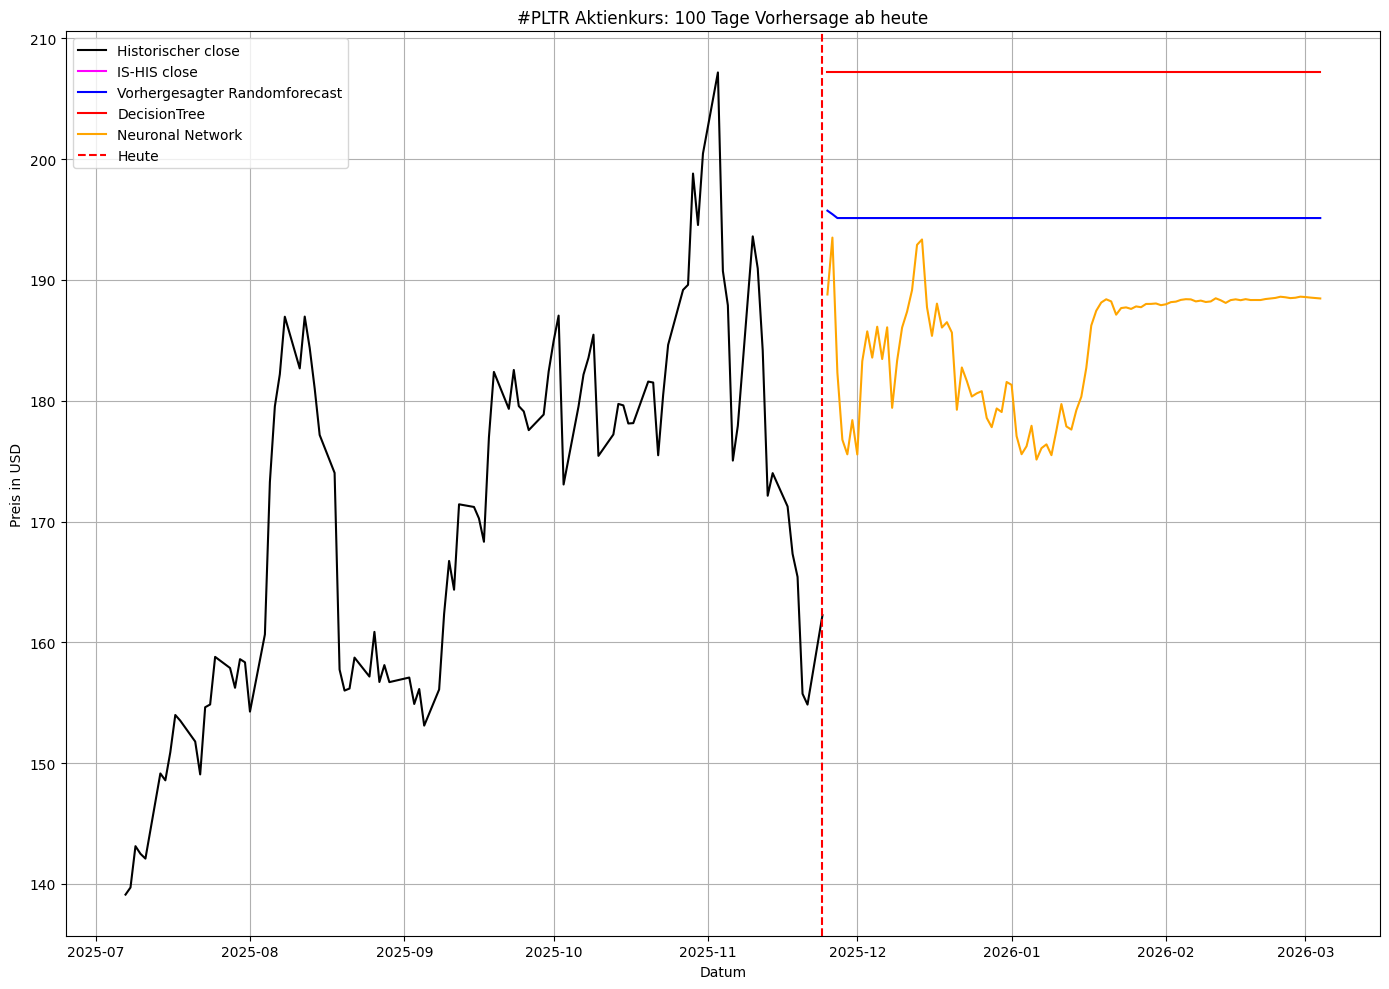

In [12]:

# Plotten
plt.figure(figsize=(14, 10))
plt.plot(df.index[-100:], df['close'].iloc[-100:], label='Historischer close', color='black')
plt.plot(df_his['date'], df_his['close'], label='IS-HIS close', color='magenta')
#plt.plot(future_dates, future_predictions, label=' Linear ', color='green')
plt.plot(future_dates, future_predictions_rf, label='Vorhergesagter Randomforecast', color='blue')
plt.plot(future_dates, future_predictions_dc, label='DecisionTree', color='red')
plt.plot(future_dates_mlp, predicted_prices_mlp, label='Neuronal Network', color='orange')

plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Heute')
plt.xlabel('Datum')
plt.ylabel('Preis in USD')
plt.title( stock_symbol + ' Aktienkurs: 100 Tage Vorhersage ab heute')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()